In [2]:
import os
import argparse
import torch
import numpy as np
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

In [3]:
import os
!ls
os.getcwd()


sample_data


'/content'

In [4]:
import cv2
items = os.listdir('/content')
print (items)
for each_image in items:
  if each_image.endswith(".jpg"):
    print (each_image)
    full_path = "/content/" + each_image
    print (full_path)
    image = cv2.imread(full_path)
    print (image)
conf_threshold = 0.90

['.config', 'sample_data']


In [5]:
CLASS_MAP = {"background": 0, "aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4, "bottle": 5, "bus": 6, "car": 7,
             "cat": 8, "chair": 9, "cow": 10, "diningtable": 11, "dog": 12, "horse": 13, "motorbike": 14, "person": 15,
             "potted plant": 16, "sheep": 17, "sofa": 18, "train": 19, "tv/monitor": 20}

In [6]:
def trimap(probs, size, conf_threshold):
    """
    This function creates a trimap based on simple dilation algorithm
    Inputs [3]: an image with probabilities of each pixel being the foreground, size of dilation kernel,
    foreground confidence threshold
    Output    : a trimap
    """
    mask = (probs > 0.05).astype(np.uint8) * 255

    pixels = 2 * size + 1
    kernel = np.ones((pixels, pixels), np.uint8)

    dilation = cv2.dilate(mask, kernel, iterations=1)

    remake = np.zeros_like(mask)
    remake[dilation == 255] = 127  # Set every pixel within dilated region as probably foreground.
    remake[probs > conf_threshold] = 255  # Set every pixel with large enough probability as definitely foreground.

    return remake

In [7]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

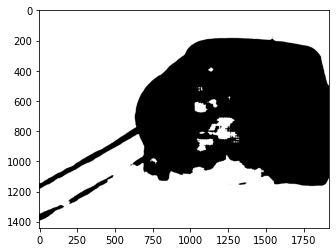

In [10]:
input_image = cv2.imread("/content/sieve.png")
plt.imshow(input_image)
original_image = input_image.copy()
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

with torch.no_grad():
    output = model(input_batch)['out'][0]
    output = torch.softmax(output, 0)

output_cat = output[CLASS_MAP["background"], ...].numpy()

trimap_image = trimap(output_cat, 7, 0.95)
# trimap_filename = os.path.basename(filename).split('.')[0] + '.png'
# cv2.imwrite(os.path.join(trimaps_path, trimap_filename), trimap_image)
plt.imshow(trimap_image,cmap = 'gray')
